<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **다음 조건에서 F beta score를 구하고 과제 제출폼에 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('/content/train.csv'), pd.read_csv('/content/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('/content/test.csv')
sample_submission= pd.read_csv('/content/submission.csv')

train , val = train_test_split(train, train_size= 0.80, test_size = 0.20, stratify=train[target], random_state=2)
train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [ ]:
train[target].value_counts(normalize=True)

0    0.760935
1    0.239065
Name: vacc_h1n1_f, dtype: float64

In [ ]:
from sklearn.metrics import accuracy_score

y_train = train[target]
major = y_train.mode()[0]
y_predic = [major] * len(y_train)

print('train accuracy :', accuracy_score(y_train,y_predic))

train accuracy : 0.7609346736648578


In [ ]:
train.describe(exclude='number') #범주형 데이터 확인

#	opinion_h1n1_vacc_effective,	opinion_h1n1_risk,	opinion_h1n1_sick_from_vacc,	opinion_seas_vacc_effective,	opinion_seas_risk,	opinion_seas_sick_from_vacc, 
#agegrp,	employment_status,	census_msa,	employment_industry,	employment_occupation,	state

,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,employment_status,census_msa,employment_industry,employment_occupation,state
count,26637,26602,26568,26519,26466,26413,33723,25466,33723,13714,13714,33723
unique,6,6,6,6,6,6,7,3,3,23,25,51
top,Somewhat Effective,Somewhat Low,Not Very Worried,Somewhat Effective,Somewhat Low,Not At All Worried,65+ Years,Employed,"MSA, Not Principle City",Health Care and Social Assistance Industries,Management Occupations,CALIFORNIA
freq,11710,9980,9229,11571,9057,11813,6821,13722,15202,2451,1769,829


In [ ]:
train.describe(exclude='number').T.sort_values(by='unique') #카디널리티 확인

,count,unique,top,freq
employment_status,25466,3,Employed,13722
census_msa,33723,3,"MSA, Not Principle City",15202
opinion_h1n1_vacc_effective,26637,6,Somewhat Effective,11710
opinion_h1n1_risk,26602,6,Somewhat Low,9980
opinion_h1n1_sick_from_vacc,26568,6,Not Very Worried,9229
opinion_seas_vacc_effective,26519,6,Somewhat Effective,11571
opinion_seas_risk,26466,6,Somewhat Low,9057
opinion_seas_sick_from_vacc,26413,6,Not At All Worried,11813
agegrp,33723,7,65+ Years,6821
employment_industry,13714,23,Health Care and Social Assistance Industries,2451


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
    selected_cols = df.select_dtypes(include=['number', 'object'])
    labels = selected_cols.nunique() # 특성별 카디널리티 리스트
    selected_features = labels[labels <= 30].index.tolist() # 카디널리티가 30보다 작은 특성만 선택합니다.
    df = df[selected_features]
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True) 
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)


In [ ]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [ ]:
!pip install category_encoders

In [ ]:
%%time
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder

# ordinal encoding
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=10, random_state=2, n_jobs=-1)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.8089194638832878
CPU times: user 869 ms, sys: 43.7 ms, total: 913 ms
Wall time: 699 ms


In [ ]:
# 오늘 과제 진행
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.94      0.88      6416
           1       0.67      0.39      0.49      2015

    accuracy                           0.81      8431
   macro avg       0.75      0.67      0.69      8431
weighted avg       0.79      0.81      0.79      8431



In [ ]:
pipe.classes_

pipe.predict(X_val)


pipe.predict_proba(X_val)

# 백신접종 확률
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred_proba

array([0. , 0.1, 0.3, ..., 0.2, 0.1, 0.6])

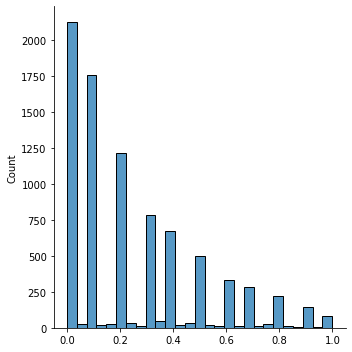

In [ ]:
import seaborn as sns
sns.displot(y_pred_proba);

False    7259
True     1172
dtype: int64

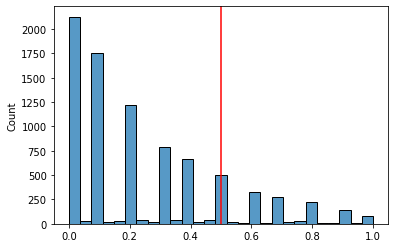

In [ ]:
# Randomforestclassifier 기본 임계값은 0.5입니다.
threshold = 0.5
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [ ]:
from ipywidgets import interact, fixed
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [ ]:
#X_train_final = pd.concat([X_train, X_val], ignore_index=True)
#y_train_final = pd.concat([y_train, y_val], ignore_index=True)
#pipe.fit(X_train_final, y_train_final)
#y_test_pred = pipe_ord.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

y_val_pred = pipe.predict(X_val)
print(f'검증 세트 F2 Score : {f1_score(y_val, y_val_pred)}')  # 기존 :  0.9787127473077886

검증 세트 F2 Score : 0.4945089425792282


In [ ]:
TP = 4442 
TN = 6165
FP = 1515
FN = 1930
total = TP + TN + FP + FN

# 정밀도
positivies = TP + FP
precision = TP/positivies
print('정밀도 :', precision)

# 재현율
real_positivies = TP + FN 

recall = TP/real_positivies
print('재현율 :', recall)

beta = 2
F_beta = (1+beta**2)*((precision*recall)/((beta**2*precision)+recall))
F_beta #  1번 0.7063126093178564"

정밀도 : 0.7456773543730065
재현율 : 0.697112366603892


0.7063126093178564

### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 과제 제출폼에 제출하세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


False    6029
True     2402
dtype: int64

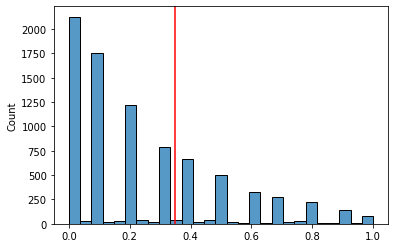

In [ ]:
# Randomforestclassifier 기본 임계값은 0.5입니다.
threshold = 0.35
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [ ]:
from ipywidgets import interact, fixed
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

#재현율은 임계값이 증가할수록 떨어진다    

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

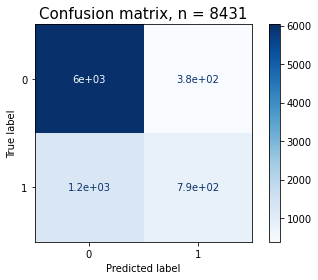

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, n_estimators = n
- **(객관식) 확률값들의 분포(종류)의 변화를 과제 제출폼에 제출하세요**
    1. 다양해진다
    2. 변화가없다


In [ ]:
# ordinal encoding
pipe1 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=None, n_estimators = 100)
)


pipe1.fit(X_train, y_train)
y_pred = pipe1.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.8239829201755426


In [ ]:
y_pred_proba = pipe1.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.036 , 0.08  , 0.4175, ..., 0.09  , 0.03  , 0.5   ])

In [ ]:

from ipywidgets import interact, fixed

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [ ]:
#달라진다

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 

## 🔥 도전과제

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 